# Practice Lab 22- Autoencoders AE
In this lab we will look at a simple autoencoder, that unsupervised algorithms that predict the input. \
The challenge is to predict the input after a compression of information, that is finding the patterns that characterize the input.\
Autoencoders are very general, other versions are Variational AE and Generative Adversarial Networks (GAN).\
We will see VAE and GAN in different practices. \
Based on Chapter 17 from Aurelien Geron's book, Hands-on Machine Learning with Scikit-Learn Keras & Tensorflow.\
Original code examples from book in github [here](https://github.com/ageron/handson-ml2)


<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/dtrad/geoml_course/blob/master/Practice22_AE.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab?
IS_COLAB = "google.colab" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

# MNIST Fashion data set
We will create an autoencoder for the images in the fashion MNIST data set. \
You can replace those images with some else (for example seismic images as will do for GANs and VAEs).

In [3]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [4]:
def show_images(X_train, y_train, first, n_images=5):
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(1, n_images, 1 + image_index)
        plt.imshow(X_train[first+image_index]);plt.title(y_train[first+image_index]);plt.axis('off')
    first=first+n_images
    return first
first=0

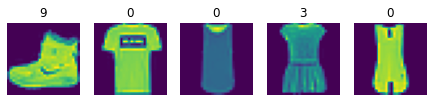

In [5]:
first=show_images(X_train, y_train, first, 5)

Although we have labels, we will not used them anywhere (unsupervised)\
In fact, we will create a metric to define accuracy based on pixels, not in the actual class.\
Notice that the metric has to be done in terms of tensors, no numpy, because they need to be converted to graphs for calculations (see Lec17 in D2L)

In [6]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

## Stacked Autoencoder 


As explained in the lecture, Autoencoders have 2 parts:
* encoder to compress the information (find a pattern) to the latent space
* decoder to decompress the information from the latent space to the original space.

The Stacked AE are build by adding the decoder on top of the encoder using the sequential method

In [7]:
tf.random.set_seed(42)
np.random.seed(42)

stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu"),
])
stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(loss="binary_crossentropy",
                   optimizer=keras.optimizers.SGD(learning_rate=1.5), metrics=[rounded_accuracy])

#notice we are not using labels when training
history = stacked_ae.fit(X_train, X_train, epochs=20,
                         validation_data=(X_valid, X_valid))

2022-11-26 09:07:25.734706: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-26 09:07:26.991420: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10237 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:09:00.0, compute capability: 8.6
2022-11-26 09:07:26.992146: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 6154 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2070 SUPER, pci bus id: 0000:05:00.0, compute capability: 7.5
2022-11-26 09:07:27.539973: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR 

Epoch 1/20
  73/1719 [>.............................] - ETA: 3s - loss: 0.5176 - rounded_accuracy: 0.7309

2022-11-26 09:07:28.942200: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1719/1719 [==============================] - 5s 2ms/step - loss: 0.3380 - rounded_accuracy: 0.8871 - val_loss: 0.3178 - val_rounded_accuracy: 0.8981
Epoch 2/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3056 - rounded_accuracy: 0.9152 - val_loss: 0.3020 - val_rounded_accuracy: 0.9204
Epoch 3/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2986 - rounded_accuracy: 0.9215 - val_loss: 0.2994 - val_rounded_accuracy: 0.9183
Epoch 4/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2948 - rounded_accuracy: 0.9249 - val_loss: 0.2938 - val_rounded_accuracy: 0.9285
Epoch 5/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2923 - rounded_accuracy: 0.9272 - val_loss: 0.2920 - val_rounded_accuracy: 0.9284
Epoch 6/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2904 - rounded_accuracy: 0.9289 - val_loss: 0.2915 - val_rounded_accuracy: 0.9305
Epoch 7/20
1719/1719 [=============================

In [9]:
def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

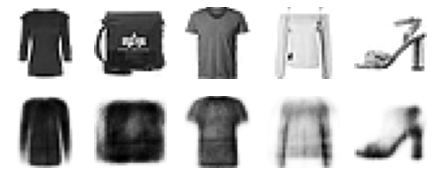

In [9]:
show_reconstructions(stacked_ae)

The encoder part acts as a very efficient dimensionality reduction engine, \
so it is common to use it as a preprocessing for classification methods that are not as efficienty for large datasets.

In [10]:
np.random.seed(42)

from sklearn.manifold import TSNE

X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE(learning_rate='auto',init='random')
X_valid_2D = tsne.fit_transform(X_valid_compressed)
X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min())

For example TSNE gives the coordinates of the transformed sets that produces the maximum separation across classes.

In [11]:
print(X_valid_2D.shape)

(5000, 2)


We use labels here but just for the plot (still all is unsupervised)

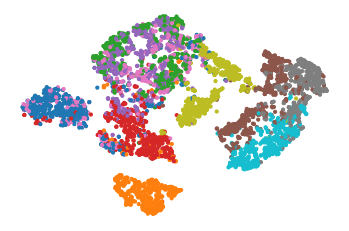

In [12]:
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap="tab10")
plt.axis("off")
plt.show()

## Convolutional Autoencoders
There are many options for autoencoders. For example, denoising, colorization, image segmentation, etc.\
For example, let us build the same model with convolutional networks instead.

In [13]:
tf.random.set_seed(42)
np.random.seed(42)

conv_encoder = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    keras.layers.Conv2D(16, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2)
])
conv_decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="VALID", activation="selu",
                                 input_shape=[3, 3, 64]),
    keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="SAME", activation="selu"),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="SAME", activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])

conv_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
                metrics=[rounded_accuracy])

In [14]:
conv_encoder.summary()
conv_decoder.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 64)         

In [15]:
history = conv_ae.fit(X_train, X_train, epochs=10,
                      validation_data=(X_valid, X_valid))

Epoch 1/10


2022-11-26 09:37:37.274433: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201


1719/1719 [==============================] - 9s 3ms/step - loss: 0.3018 - rounded_accuracy: 0.9187 - val_loss: 0.2848 - val_rounded_accuracy: 0.9287
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2756 - rounded_accuracy: 0.9413 - val_loss: 0.2729 - val_rounded_accuracy: 0.9456
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2708 - rounded_accuracy: 0.9462 - val_loss: 0.2696 - val_rounded_accuracy: 0.9497
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2682 - rounded_accuracy: 0.9490 - val_loss: 0.2685 - val_rounded_accuracy: 0.9492
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2664 - rounded_accuracy: 0.9509 - val_loss: 0.2673 - val_rounded_accuracy: 0.9505
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2651 - rounded_accuracy: 0.9525 - val_loss: 0.2657 - val_rounded_accuracy: 0.9534
Epoch 7/10
1719/1719 [=============================

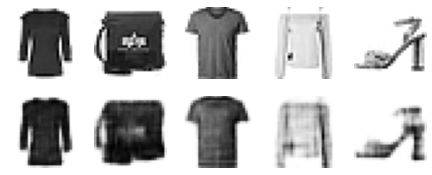

In [16]:
show_reconstructions(conv_ae)
plt.show()

to compare, here is the previous one with dense networks

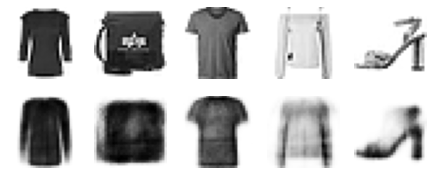

In [17]:
show_reconstructions(stacked_ae)

## Autoencoder constraints
Essentially AE impose constrains to force the network to learn the important features. \
This can be done in different ways. Above we used the dimensionality reduction in the latent space.\
There are other ways:
* introducing noise
* removing features with dropout
* applying sparsity

## Stacked Denoising Autoencoders
Since the data are the labels, we can play a trick of creating a fake training data set with noise but keep the targets clean.\
With this, we can use AE for denoising by training them with data with noise, but forcing the output to be clean. \
To make it all in one, we can even add the noise inside the encoder.\
This example is with Random Gaussian noise (not too hard) but other types of noise (coherent) may be harder.

In [18]:
tf.random.set_seed(42)
np.random.seed(42)

denoising_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.GaussianNoise(0.2),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])
denoising_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
denoising_ae = keras.models.Sequential([denoising_encoder, denoising_decoder])
denoising_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
                     metrics=[rounded_accuracy])
history = denoising_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3509 - rounded_accuracy: 0.8766 - val_loss: 0.3182 - val_rounded_accuracy: 0.9036
Epoch 2/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3121 - rounded_accuracy: 0.9097 - val_loss: 0.3087 - val_rounded_accuracy: 0.9156
Epoch 3/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3057 - rounded_accuracy: 0.9152 - val_loss: 0.3035 - val_rounded_accuracy: 0.9192
Epoch 4/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3021 - rounded_accuracy: 0.9183 - val_loss: 0.2999 - val_rounded_accuracy: 0.9207
Epoch 5/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2992 - rounded_accuracy: 0.9209 - val_loss: 0.2968 - val_rounded_accuracy: 0.9251
Epoch 6/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2969 - rounded_accuracy: 0.9229 - val_loss: 0.2946 - val_rounded_accuracy: 0.9272
Epoch 7/10
1719/1719 [==================

To test the denoising, we input the data with Gaussian Noise by using the layers.GaussianNoise in training mode (applies the noise).

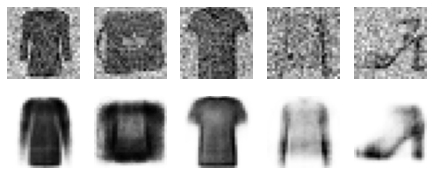

In [19]:
tf.random.set_seed(42)
np.random.seed(42)

noise = keras.layers.GaussianNoise(0.2)
show_reconstructions(denoising_ae, noise(X_valid, training=True))
plt.show()

Another way to constrain the main features is by using dropout. \
Removing some of the features in the encoder is similar to apply sparseness in inversion (which is another way for denoising)

In [20]:
tf.random.set_seed(42)
np.random.seed(42)

dropout_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])
dropout_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
dropout_ae = keras.models.Sequential([dropout_encoder, dropout_decoder])
dropout_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
                   metrics=[rounded_accuracy])
history = dropout_ae.fit(X_train, X_train, epochs=10,
                         validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3568 - rounded_accuracy: 0.8710 - val_loss: 0.3200 - val_rounded_accuracy: 0.9041
Epoch 2/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3182 - rounded_accuracy: 0.9032 - val_loss: 0.3126 - val_rounded_accuracy: 0.9110
Epoch 3/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3128 - rounded_accuracy: 0.9075 - val_loss: 0.3075 - val_rounded_accuracy: 0.9153
Epoch 4/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3092 - rounded_accuracy: 0.9102 - val_loss: 0.3041 - val_rounded_accuracy: 0.9178
Epoch 5/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3067 - rounded_accuracy: 0.9123 - val_loss: 0.3015 - val_rounded_accuracy: 0.9193
Epoch 6/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3048 - rounded_accuracy: 0.9139 - val_loss: 0.3014 - val_rounded_accuracy: 0.9172
Epoch 7/10
1719/1719 [==================

Just as before, we input the images with dropout to see how the AE interpolate them.

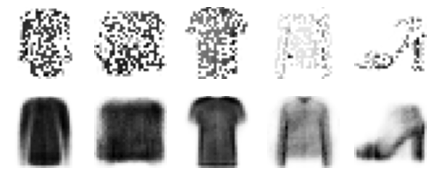

In [21]:
tf.random.set_seed(42)
np.random.seed(42)

dropout = keras.layers.Dropout(0.5)
show_reconstructions(dropout_ae, dropout(X_valid, training=True))